In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [3]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'gaussian', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*rbf.*$)', 'gaussian', regex=True)
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [4]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data(random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_separable_data(random_state=123456)

## Hinge loss

### Primal formulation

In [40]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [41]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    
    if hasattr(svc, 'train_loss_history'):
        
        # (f_t - f*) / f*
        f_star = np.full_like(svc.train_loss_history, svc.loss.f_star())
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                 np.maximum(np.abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y),
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..............................................C=0.1; total time=   7.2s
[CV] END ................................................C=1; total time=   3.4s
[CV] END ...............................................C=10; total time=   0.9s


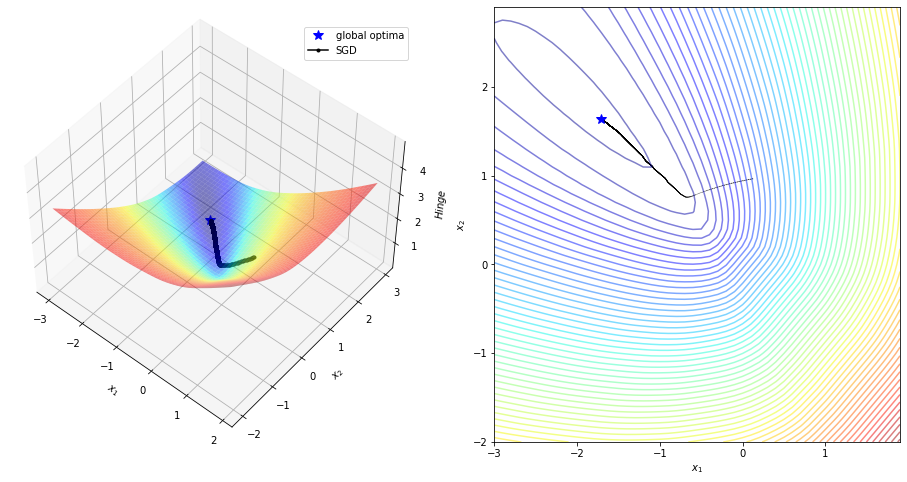

In [42]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

grid.best_estimator_.loss.x_opt = grid.best_estimator_.loss.x_star()[:-1] # remove the intercept weight to plot in 2D
grid.best_estimator_.loss.X = grid.best_estimator_.loss.X[:, :-1]  # remove the intercept column to plot in 2D
hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                  x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, 
                                              color='k', label='SGD')

In [43]:
none_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l1_svc_cv_results.insert(0, 'solver', 'sgd')
none_primal_l1_svc_cv_results.insert(1, 'momentum', 'none')
none_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   7.062483     0.975    7196    36
                1.0   3.250063     0.985    4092    15
                10.0  0.795309     0.980     947    10

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..............................................C=0.1; total time=   4.5s
[CV] END ................................................C=1; total time=   1.9s
[CV] END ...............................................C=10; total time=   0.5s


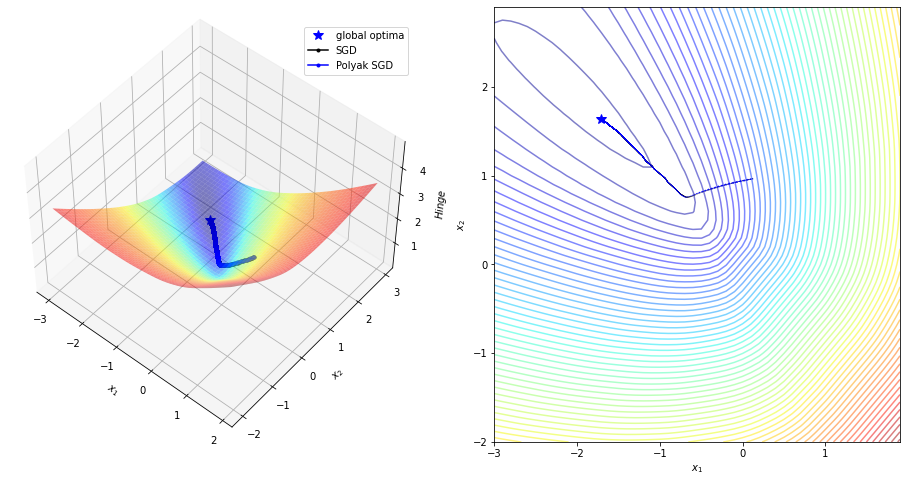

In [44]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.5, 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='Polyak SGD')
hinge_loss_opt

In [45]:
polyak_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l1_svc_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l1_svc_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    polyak   0.1   4.450933     0.975    3589    37
                1.0   1.794078     0.985    2098    16
                10.0  0.367355     0.980     467    10

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..............................................C=0.1; total time=   3.7s
[CV] END ................................................C=1; total time=   2.0s
[CV] END ...............................................C=10; total time=   0.6s


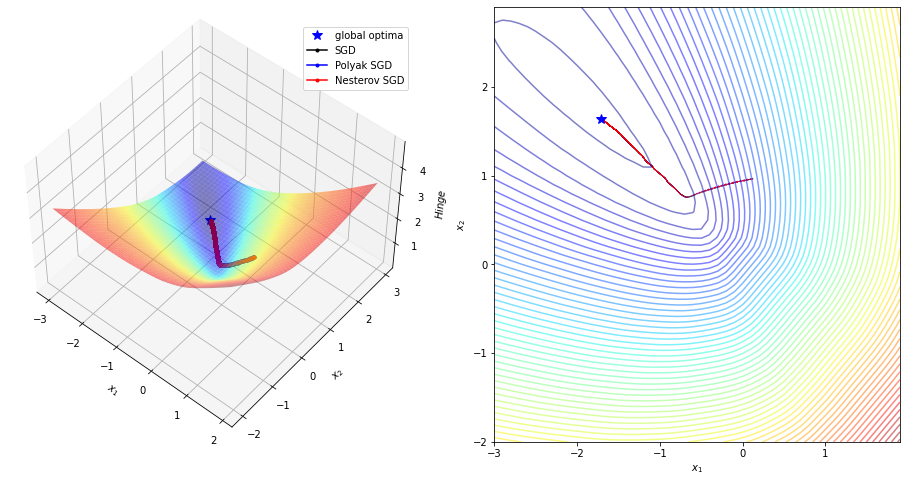

In [46]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.5, 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='Nesterov SGD')
hinge_loss_opt.savefig('./tex/img/l1_svc_loss.png')
hinge_loss_opt

In [47]:
nesterov_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l1_svc_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l1_svc_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    nesterov 0.1   3.677246     0.975    4344    37
                1.0   1.788335     0.985    2115    16
                10.0  0.414720     0.980     472    10

In [48]:
custom_primal_l1_svc_cv_results = none_primal_l1_svc_cv_results.append(
    polyak_primal_l1_svc_cv_results).append(
    nesterov_primal_l1_svc_cv_results)
custom_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   7.062483     0.975    7196    36
                1.0   3.250063     0.985    4092    15
                10.0  0.795309     0.980     947    10
       polyak   0.1   4.450933     0.975    3589    37
                1.0   1.794078     0.985    2098    16
                10.0  0.367355     0.980     467    10
       nesterov 0.1   3.677246     0.975    4344    37
                1.0   1.788335     0.985    2115    16
                10.0  0.414720     0.980     472    10

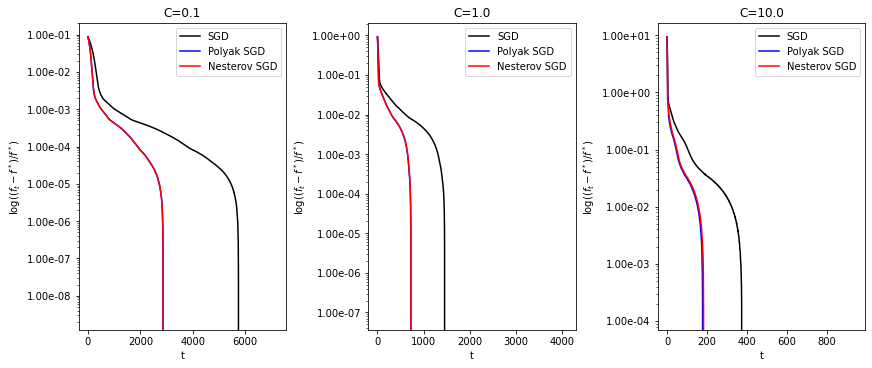

In [49]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
        loss.set_title('C={:.1f}'.format(C))
        loss.set_xlabel('t')
        loss.set_yscale('log')
        loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
        loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svc_loss_history.png')

In [50]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', 
                                max_iter=10000, 
                                random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [51]:
liblinear_primal_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l1_svc_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l1_svc_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l1_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
liblinear -        0.1   0.007178     0.980      31    37
                   1.0   0.004740     0.985     332    16
                   10.0  0.002364     0.985    1183     7

In [52]:
primal_l1_svc_cv_results = custom_primal_l1_svc_cv_results.append(liblinear_primal_l1_svc_cv_results)
primal_l1_svc_cv_results.to_latex('./tex/experiments/primal_l1_svc.tex', 
                                  caption='Primal $\protect \mathcal{L}_1$-SVC results', 
                                  label='primal_l1_svc_cv_results', position='H')
primal_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
sgd       none     0.1   7.062483     0.975    7196    36
                   1.0   3.250063     0.985    4092    15
                   10.0  0.795309     0.980     947    10
          polyak   0.1   4.450933     0.975    3589    37
                   1.0   1.794078     0.985    2098    16
                   10.0  0.367355     0.980     467    10
          nesterov 0.1   3.677246     0.975    4344    37
                   1.0   1.788335     0.985    2115    16
                   10.0  0.414720     0.980     472    10
liblinear -        0.1   0.007178     0.980      31    37
                   1.0   0.004740     0.985     332    16
                   10.0  0.002364     0.985    1183     7

### Dual formulations

In [21]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import AugmentedLagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [22]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super(SklSVC, self).fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [23]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    
    if(hasattr(svc, 'train_loss_history') and
                isinstance(svc.obj, AugmentedLagrangianQuadratic)):
        
        # (f_t - f*) / f*
        f_star = np.full_like(svc.train_loss_history, svc.obj.f_star())
        dual = 'reg_bias' if svc.reg_intercept else 'unreg_bias'
        kernel = svc.kernel.__class__.__name__
        train_loss_history[dual][kernel][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                            np.maximum(np.abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


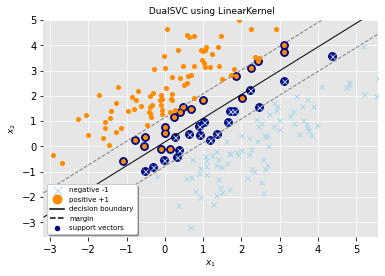

In [56]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel()),
                    param_grid={'C': [0.1, 1, 10],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svc_hyperplane.png')

In [57]:
custom_linear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_l1_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_l1_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                     
cvxopt 0.1   0.079530     0.985       9    38
       1.0   0.073912     0.980      10    17
       10.0  0.071737     0.980      10    11
smo    0.1   0.158289     0.985      33    38
       1.0   0.209209     0.980      62    17
       10.0  0.352789     0.980     295    10

In [58]:
grid = GridSearchCV(SklSVC(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [59]:
libsvm_linear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_l1_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_l1_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                     
libsvm 0.1   0.007530     0.985      37    38
       1.0   0.008367     0.985     243    17
       10.0  0.003456     0.985     194    10

In [60]:
linear_dual_l1_svc_cv_results = custom_linear_dual_l1_svc_cv_results.append(libsvm_linear_dual_l1_svc_cv_results)
linear_dual_l1_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_l1_svc_cv_results.to_latex('./tex/experiments/linear_dual_l1_svc.tex', 
                                       caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                       label='linear_dual_l1_svc_cv_results', position='H')
linear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                     
smo    0.1   0.158289     0.985      33    38
       1.0   0.209209     0.980      62    17
       10.0  0.352789     0.980     295    10
libsvm 0.1   0.007530     0.985      37    38
       1.0   0.008367     0.985     243    17
       10.0  0.003456     0.985     194    10
cvxopt 0.1   0.079530     0.985       9    38
       1.0   0.073912     0.980      10    17
       10.0  0.071737     0.980      10    11

##### Nonlinear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


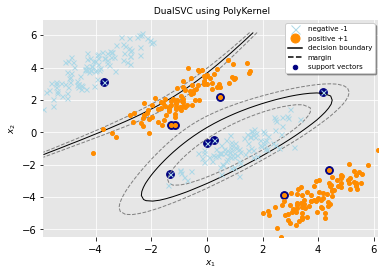

In [14]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svc_hyperplane.png')

In [62]:
poly_nonlinear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_l1_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_l1_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                     
cvxopt poly   0.1   0.487677    0.8575      10   143
              1.0   0.693849    0.6775      10    31
              10.0  0.610578    0.9475      10    10
smo    poly   0.1   1.096614    0.8675     121   142
              1.0   0.999406    0.6825     143    30
              10.0  0.680124    0.9475      65    10

Fitting 1 folds for each of 6 candidates, totalling 6 fits


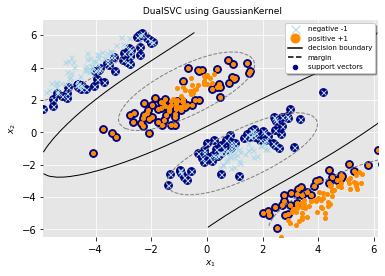

In [63]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svc_hyperplane.png')

In [64]:
gaussian_nonlinear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
gaussian_nonlinear_dual_l1_svc_cv_results.sort_values(['solver'], inplace=True)
gaussian_nonlinear_dual_l1_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
gaussian_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel   C                                     
cvxopt gaussian 0.1   0.426778       1.0      10   222
                1.0   0.568489       1.0      10    49
                10.0  0.557587       1.0      10    14
smo    gaussian 0.1   0.878962       1.0      65   222
                1.0   0.860773       1.0      76    48
                10.0  0.525582       1.0      29    13

In [65]:
custom_nonlinear_dual_l1_svc_cv_results = poly_nonlinear_dual_l1_svc_cv_results.append(gaussian_nonlinear_dual_l1_svc_cv_results)
custom_nonlinear_dual_l1_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel   C                                     
cvxopt gaussian 0.1   0.426778    1.0000      10   222
                1.0   0.568489    1.0000      10    49
                10.0  0.557587    1.0000      10    14
       poly     0.1   0.487677    0.8575      10   143
                1.0   0.693849    0.6775      10    31
                10.0  0.610578    0.9475      10    10
smo    gaussian 0.1   0.878962    1.0000      65   222
                1.0   0.860773    1.0000      76    48
                10.0  0.525582    1.0000      29    13
       poly     0.1   1.096614    0.8675     121   142
                1.0   0.999406    0.6825     143    30
                10.0  0.680124    0.9475      65    10

In [66]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [0.1, 1, 10],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [0.1, 1, 10],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [67]:
libsvm_nonlinear_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_l1_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_l1_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_l1_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel   C                                     
libsvm gaussian 0.1   0.011811       1.0     131   222
                1.0   0.007152       1.0     252    50
                10.0  0.003799       1.0     134    13
       poly     0.1   0.022929       1.0     210   143
                1.0   0.010823       1.0     233    30
                10.0  0.003304       1.0     118    10

In [68]:
nonlinear_dual_l1_svc_cv_results = custom_nonlinear_dual_l1_svc_cv_results.append(libsvm_nonlinear_dual_l1_svc_cv_results)
nonlinear_dual_l1_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_l1_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svc.tex', 
                                          caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                          label='nonlinear_dual_l1_svc_cv_results', position='H')
nonlinear_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel   C                                     
smo    gaussian 0.1   0.878962    1.0000      65   222
                1.0   0.860773    1.0000      76    48
                10.0  0.525582    1.0000      29    13
       poly     0.1   1.096614    0.8675     121   142
                1.0   0.999406    0.6825     143    30
                10.0  0.680124    0.9475      65    10
libsvm gaussian 0.1   0.011811    1.0000     131   222
                1.0   0.007152    1.0000     252    50
                10.0  0.003799    1.0000     134    13
       poly     0.1   0.022929    1.0000     210   143
                1.0   0.010823    1.0000     233    30
                10.0  0.003304    1.0000     118    10
cvxopt gaussian 0.1   0.426778    1.0000      10   222
                1.0   0.568489    1.0000      10    49
                10.0  0.557587    1.0000      10    14
       poly     0.1   0.487677    0.8575      10   143
                1.0   0.693849    0.6775      10    31
                10.0  0.610578    0.9475      10    10

#### Lagrangian Dual

##### Linear

In [24]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=500000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'C': [0.1, 1, 10],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV] END ..........................C=0.1, reg_intercept=True; total time= 1.0min
[CV] END .........................C=0.1, reg_intercept=False; total time= 1.4min
[CV] END ............................C=1, reg_intercept=True; total time=  56.9s
[CV] END ...........................C=1, reg_intercept=False; total time= 1.0min
[CV] END ...........................C=10, reg_intercept=True; total time= 1.1min
[CV] END ..........................C=10, reg_intercept=False; total time= 1.1min


In [25]:
linear_lagrangian_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l1_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_l1_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l1_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svc.tex', 
                                                  caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                                  label='linear_lagrangian_dual_l1_svc_cv_results', position='H')
linear_lagrangian_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                      
reg_bias   0.1   61.744181     0.985   62016    37
           1.0   56.839004     0.980   63970    17
           10.0  63.682241     0.980   71086    10
unreg_bias 0.1   82.884538     0.985   93132    38
           1.0   62.633623     0.980   67696    17
           10.0  66.570828     0.980   74848    10

##### Nonlinear

In [26]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            optimizer=AdaGrad, 
                            max_iter=500000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END C=0.1, kernel=PolyKernel(coef0=1), reg_intercept=True; total time= 3.9min
[CV] END C=0.1, kernel=PolyKernel(coef0=1), reg_intercept=False; total time= 4.2min
[CV] END .C=0.1, kernel=GaussianKernel(), reg_intercept=True; total time= 2.0min
[CV] END C=0.1, kernel=GaussianKernel(), reg_intercept=False; total time= 2.0min
[CV] END C=1, kernel=PolyKernel(coef0=1), reg_intercept=True; total time= 4.0min
[CV] END C=1, kernel=PolyKernel(coef0=1), reg_intercept=False; total time= 4.7min
[CV] END ...C=1, kernel=GaussianKernel(), reg_intercept=True; total time= 7.2min
[CV] END ..C=1, kernel=GaussianKernel(), reg_intercept=False; total time=10.7min
[CV] END C=10, kernel=PolyKernel(coef0=1), reg_intercept=True; total time= 4.5min
[CV] END C=10, kernel=PolyKernel(coef0=1), reg_intercept=False; total time= 4.5min
[CV] END ..C=10, kernel=GaussianKernel(), reg_intercept=True; total time= 5.7min
[CV] END .C=10, kernel=GaussianKernel()

In [27]:
nonlinear_lagrangian_dual_l1_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l1_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l1_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_l1_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svc.tex', 
                                                     caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                                     label='nonlinear_lagrangian_dual_l1_svc_cv_results', position='H')
nonlinear_lagrangian_dual_l1_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel   C                                       
reg_bias   gaussian 0.1   120.097406    1.0000   48809   222
                    1.0   432.937375    1.0000  165224    50
                    10.0  342.829144    1.0000  121122    13
           poly     0.1   232.273688    0.8575   96857   143
                    1.0   241.040231    0.6775  104275    31
                    10.0  272.063762    0.9475  103227    10
unreg_bias gaussian 0.1   121.112219    1.0000   49604   222
                    1.0   640.577801    1.0000  250943    50
                    10.0  557.231243    1.0000  202406    13
           poly     0.1   252.005305    0.8600  102946   143
                    1.0   284.020057    0.6775  124476    31
                    10.0  271.631405    0.9475  108691    10

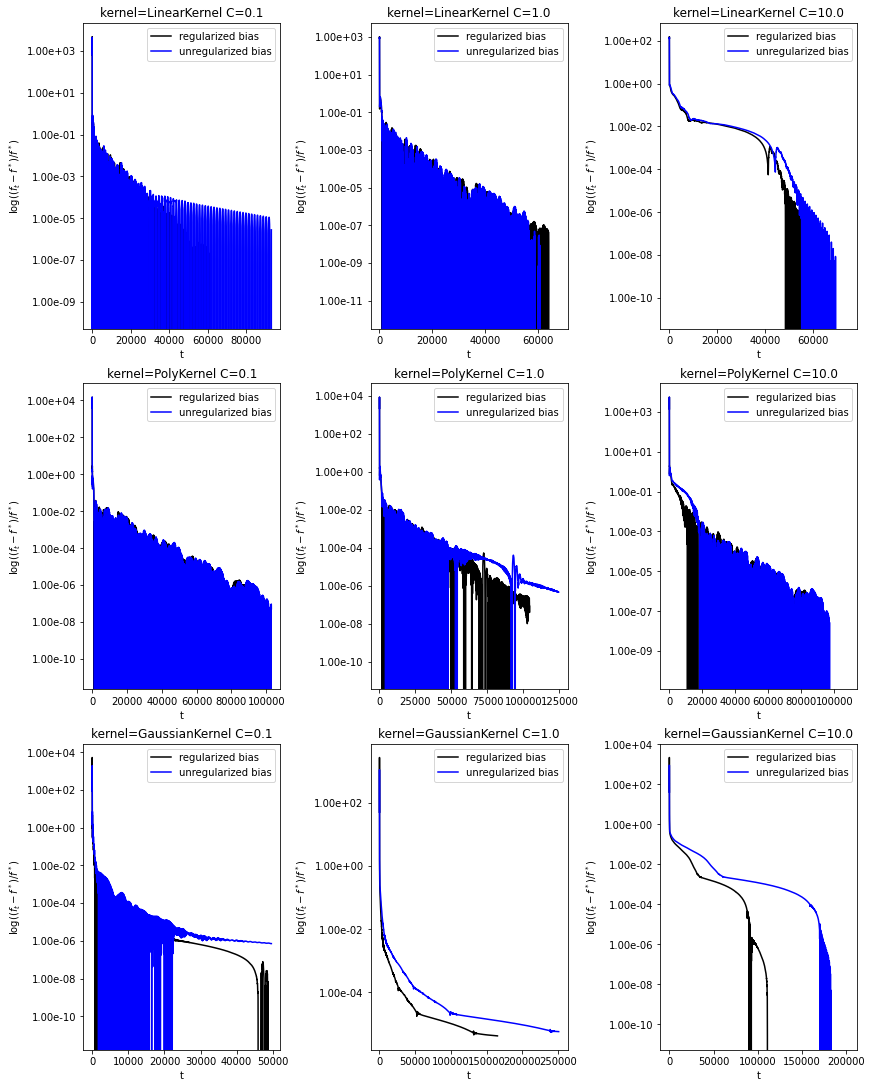

In [28]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual][0], label=colors[dual][1])
            loss.set_title('kernel={} C={:.1f}'.format(kernel, C))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l1_svc_loss_history.png')

## Squared Hinge loss

### Primal formulation

In [20]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [21]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    
    if hasattr(svc, 'train_loss_history'):
        
        # (f_t - f*) / f*
        f_star = np.full_like(svc.train_loss_history, svc.loss.f_star())
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                 np.maximum(np.abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..............................................C=0.1; total time=   4.6s
[CV] END ................................................C=1; total time=   4.2s
[CV] END ...............................................C=10; total time=   2.6s


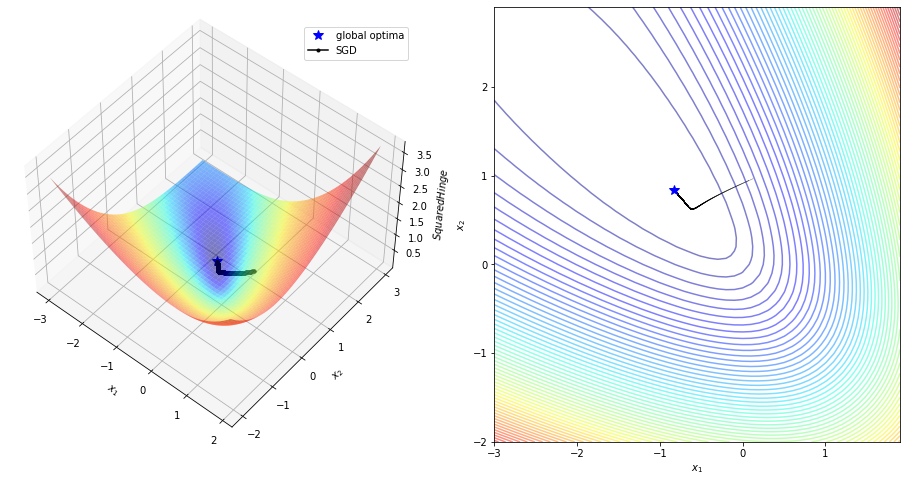

In [71]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

grid.best_estimator_.loss.x_opt = grid.best_estimator_.loss.x_star()[:-1] # remove the intercept weight to plot in 2D
grid.best_estimator_.loss.X = grid.best_estimator_.loss.X[:, :-1]  # remove the intercept column to plot in 2D
squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                          x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='SGD')

In [72]:
none_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_l2_svc_cv_results.insert(0, 'solver', 'sgd')
none_primal_l2_svc_cv_results.insert(1, 'momentum', 'none')
none_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   4.478252      0.98    5661    49
                1.0   4.060005      0.98    5165    25
                10.0  2.564839      0.98    1895    19

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..............................................C=0.1; total time=   2.9s
[CV] END ................................................C=1; total time=   2.4s
[CV] END ...............................................C=10; total time=   0.2s


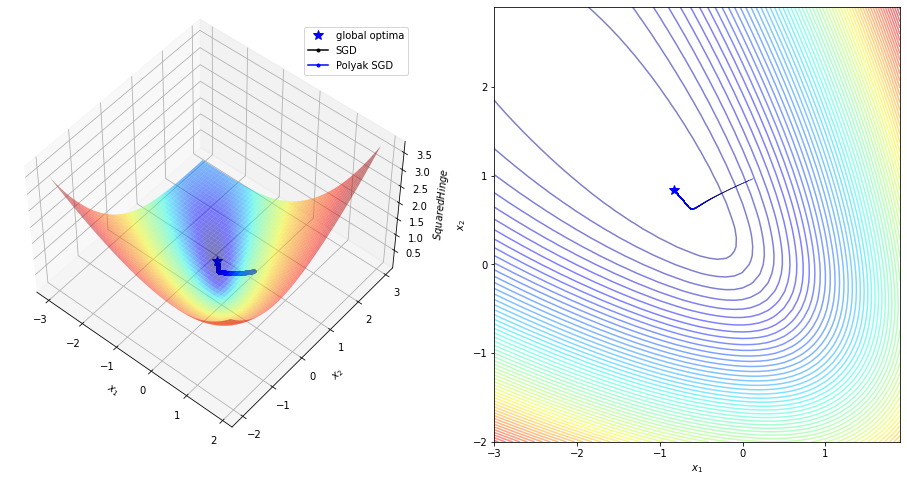

In [73]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.5, 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='Polyak SGD')
squared_hinge_loss_opt

In [74]:
polyak_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_l2_svc_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_l2_svc_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    polyak   0.1   2.756118     0.980    3287    49
                1.0   2.298601     0.980    2827    25
                10.0  0.023973     0.975      10    20

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..............................................C=0.1; total time=   2.8s
[CV] END ................................................C=1; total time=   2.4s
[CV] END ...............................................C=10; total time=   0.8s


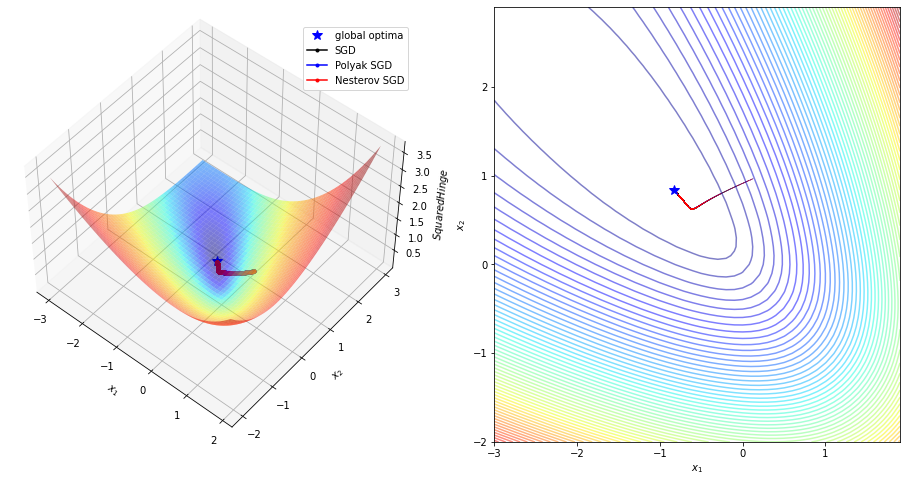

In [75]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.5, 
                              early_stopping=True, 
                              max_iter=10000, 
                              tol=1e-8, 
                              random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='Nesterov SGD')
squared_hinge_loss_opt.savefig('./tex/img/l2_svc_loss.png')
squared_hinge_loss_opt

In [76]:
nesterov_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_l2_svc_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_l2_svc_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    nesterov 0.1   2.714415      0.98    3291    49
                1.0   2.367481      0.98    2835    25
                10.0  0.731884      0.98     849    19

In [77]:
custom_primal_l2_svc_cv_results = none_primal_l2_svc_cv_results.append(
    polyak_primal_l2_svc_cv_results).append(
    nesterov_primal_l2_svc_cv_results)
custom_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                     
sgd    none     0.1   4.478252     0.980    5661    49
                1.0   4.060005     0.980    5165    25
                10.0  2.564839     0.980    1895    19
       polyak   0.1   2.756118     0.980    3287    49
                1.0   2.298601     0.980    2827    25
                10.0  0.023973     0.975      10    20
       nesterov 0.1   2.714415     0.980    3291    49
                1.0   2.367481     0.980    2835    25
                10.0  0.731884     0.980     849    19

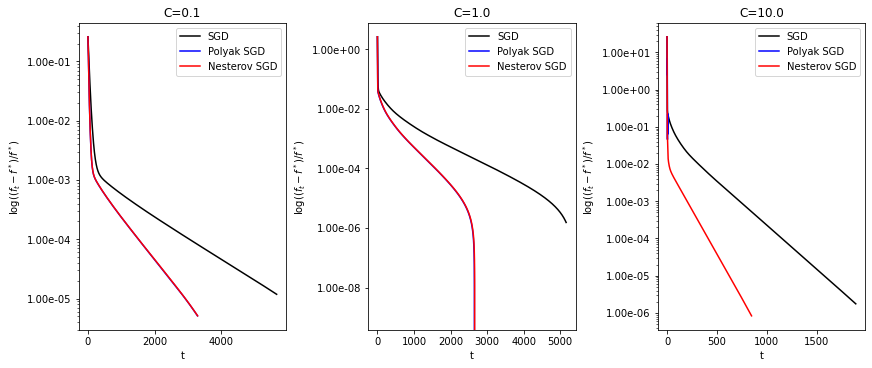

In [78]:
colors = {'none': ('k', 'SGD'),
          'polyak': ('b', 'Polyak SGD'),
          'nesterov': ('r', 'Nesterov SGD')}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum][0], label=colors[momentum][1])
        loss.set_title('C={:.1f}'.format(C))
        loss.set_xlabel('t')
        loss.set_yscale('log')
        loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
        loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svc_loss_history.png')

In [79]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', 
                                max_iter=10000, 
                                random_state=123456),
                    param_grid={'C': [0.1, 1, 10]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy)
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [80]:
liblinear_primal_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_l2_svc_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_l2_svc_cv_results.insert(1, 'momentum', '-')
liblinear_primal_l2_svc_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
liblinear -        0.1   0.003543      0.98      52    46
                   1.0   0.005556      0.98     563    25
                   10.0  0.008653      0.98    3129    19

In [81]:
primal_l2_svc_cv_results = custom_primal_l2_svc_cv_results.append(liblinear_primal_l2_svc_cv_results)
primal_l2_svc_cv_results.to_latex('./tex/experiments/primal_l2_svc.tex', 
                                  caption='Primal $\protect \mathcal{L}_2$-SVC results', 
                                  label='primal_l2_svc_cv_results', position='H')
primal_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                     
sgd       none     0.1   4.478252     0.980    5661    49
                   1.0   4.060005     0.980    5165    25
                   10.0  2.564839     0.980    1895    19
          polyak   0.1   2.756118     0.980    3287    49
                   1.0   2.298601     0.980    2827    25
                   10.0  0.023973     0.975      10    20
          nesterov 0.1   2.714415     0.980    3291    49
                   1.0   2.367481     0.980    2835    25
                   10.0  0.731884     0.980     849    19
liblinear -        0.1   0.003543     0.980      52    46
                   1.0   0.005556     0.980     563    25
                   10.0  0.008653     0.980    3129    19

### Lagrangian Dual

In [14]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [15]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    
    # (f_t - f*) / f*
    f_star = np.full_like(svc.train_loss_history, svc.obj.f_star())
    dual = 'reg_bias' if svc.reg_intercept else 'unreg_bias'
    kernel = svc.kernel.__class__.__name__
    train_loss_history[dual][kernel][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                        np.maximum(np.abs(f_star), 1))
    
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Linear

In [16]:
grid = GridSearchCV(DualSVC(loss=squared_hinge, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            max_iter=500000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'C': [0.1, 1, 10],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV] END ..........................C=0.1, reg_intercept=True; total time=   5.8s
[CV] END .........................C=0.1, reg_intercept=False; total time=   5.7s
[CV] END ............................C=1, reg_intercept=True; total time=  28.7s
[CV] END ...........................C=1, reg_intercept=False; total time=  29.4s
[CV] END ...........................C=10, reg_intercept=True; total time= 2.1min
[CV] END ..........................C=10, reg_intercept=False; total time= 2.2min


In [17]:
linear_lagrangian_dual_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_l2_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_l2_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_l2_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l2_svc.tex', 
                                                  caption='Lagrangian Dual linear $\protect \mathcal{L}_2$-SVC results', 
                                                  label='linear_lagrangian_dual_l2_svc_cv_results', position='H')
linear_lagrangian_dual_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                       
reg_bias   0.1     5.719586      0.98    6020    46
           1.0    28.664430      0.98   31786    25
           10.0  123.660781      0.98  120271    19
unreg_bias 0.1     5.621373      0.98    6391    47
           1.0    29.349832      0.98   32856    25
           10.0  131.813391      0.98  127862    19

#### Nonlinear

In [18]:
grid = GridSearchCV(DualSVC(loss=squared_hinge, 
                            optimizer=AdaGrad, 
                            max_iter=500000, 
                            learning_rate=1., 
                            tol=1e-6, 
                            random_state=123456),
                    param_grid={'C': [0.1, 1, 10],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation trick
                    refit=False,
                    return_train_score=True,
                    verbose=2).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END C=0.1, kernel=PolyKernel(coef0=1), reg_intercept=True; total time=  14.7s
[CV] END C=0.1, kernel=PolyKernel(coef0=1), reg_intercept=False; total time=  15.4s
[CV] END .C=0.1, kernel=GaussianKernel(), reg_intercept=True; total time=   1.9s
[CV] END C=0.1, kernel=GaussianKernel(), reg_intercept=False; total time=   3.8s
[CV] END C=1, kernel=PolyKernel(coef0=1), reg_intercept=True; total time= 1.7min
[CV] END C=1, kernel=PolyKernel(coef0=1), reg_intercept=False; total time= 1.9min
[CV] END ...C=1, kernel=GaussianKernel(), reg_intercept=True; total time=  21.1s
[CV] END ..C=1, kernel=GaussianKernel(), reg_intercept=False; total time=  36.5s
[CV] END C=10, kernel=PolyKernel(coef0=1), reg_intercept=True; total time= 3.9min
[CV] END C=10, kernel=PolyKernel(coef0=1), reg_intercept=False; total time= 4.7min
[CV] END ..C=10, kernel=GaussianKernel(), reg_intercept=True; total time= 2.9min
[CV] END .C=10, kernel=GaussianKernel()

In [19]:
nonlinear_lagrangian_dual_l2_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_l2_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_l2_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_l2_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l2_svc.tex', 
                                                     caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_2$-SVC results', 
                                                     label='nonlinear_lagrangian_dual_l2_svc_cv_results', position='H')
nonlinear_lagrangian_dual_l2_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel   C                                       
reg_bias   gaussian 0.1     1.852377    1.0000    1693   345
                    1.0    20.990246    1.0000   11169   130
                    10.0  175.199314    1.0000   59626    33
           poly     0.1    14.658976    0.8550   10137   233
                    1.0   104.467894    0.6950   51914    80
                    10.0  234.733651    0.7300   91925    16
unreg_bias gaussian 0.1     3.684700    1.0000    3443   344
                    1.0    36.415391    1.0000   20156   130
                    10.0  211.875457    1.0000   96154    33
           poly     0.1    15.365086    0.8625   10859   234
                    1.0   112.171623    0.6950   54832    80
                    10.0  282.238163    0.7300   97414    16

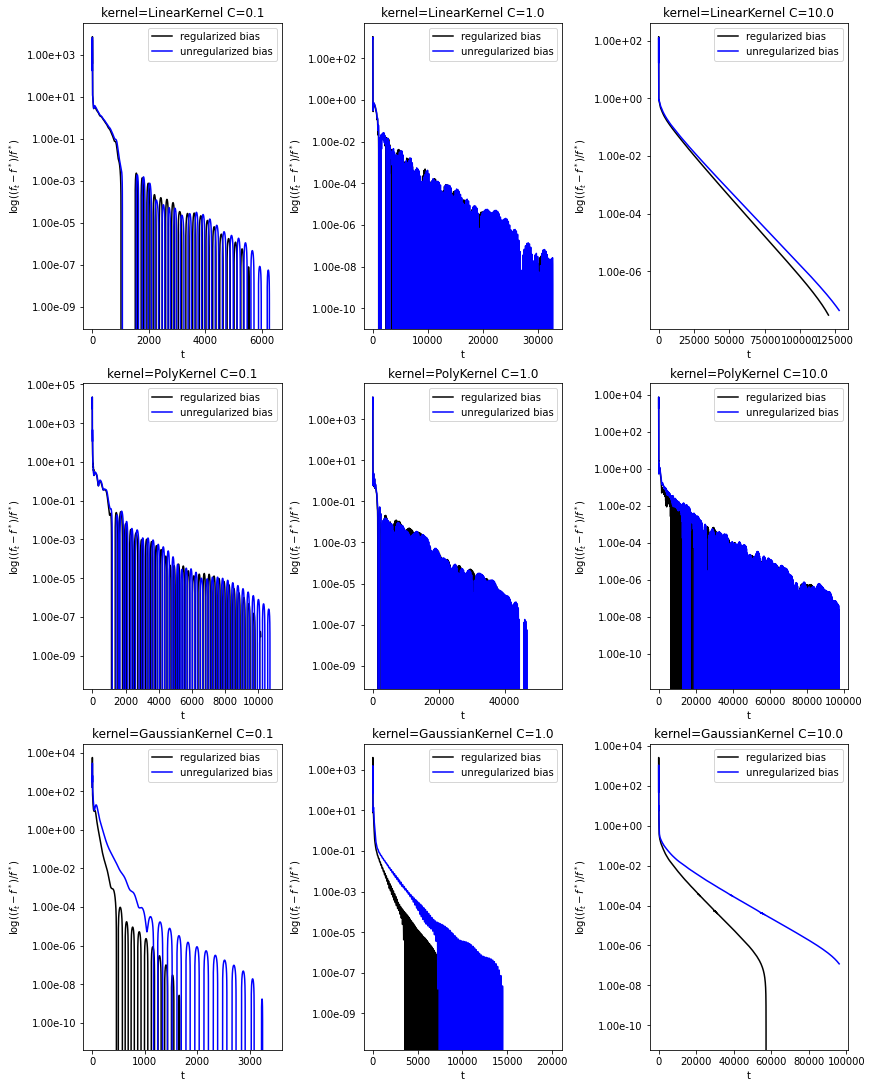

In [20]:
colors = {'reg_bias': ('k', 'regularized bias'),
          'unreg_bias': ('b', 'unregularized bias')}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual][0], label=colors[dual][1])
            loss.set_title('kernel={} C={:.1f}'.format(kernel, C))
            loss.set_xlabel('t')
            loss.set_yscale('log')
            loss.set_ylabel('$\log((f_t - f^*) / f^*)$')
            loss.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
            loss.legend().get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l2_svc_loss_history.png')